In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import scipy.stats as stats
import matplotlib.pyplot as plt
from IPython import display
import pandas as pd
import numpy as np
import seaborn as sns
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset
display.set_matplotlib_formats('svg')

In [ ]:
data = pd.read_csv("PATH/ml_sample4.csv")
data = data.sample(frac=1).reset_index(drop=True)

data.head()

,location,description,url,followers_count,friends_count,listed_count,favourites_count,geo_enabled,verified,statuses_count,profile_background_image_url_https,profile_background_tile,profile_image_url,profile_use_background_image,has_extended_profile,default_profile,default_profile_image,profile_banner_url,entities.url.urls,class
0,0,0,0,447,260,5,3386,1,0,30794,1,1,1,1,0,0,0,1,0,1
1,1,94,0,79,866,3,1030,1,0,2191,1,1,1,1,1,0,0,1,0,1
2,0,36,0,82,1107,1,22,0,0,320,1,0,1,1,0,1,0,1,0,1
3,1,30,1,501,1066,6,579,1,0,3789,1,0,1,1,1,1,0,1,1,1
4,1,31,0,958,257,4,412,0,0,1913,1,0,1,1,0,1,0,1,0,1


# Import and process the data

In [ ]:
labels = torch.tensor( data['class'] ).long()
data=data.drop(['class','url'],axis=1) 

data=data.apply(stats.zscore);
sample = torch.tensor(data.values).float()


In [ ]:
train_data,test_data, train_labels,test_labels = train_test_split(sample, labels, test_size=.2)

tensor([0, 0, 1,  ..., 1, 0, 1])

# Create the ANN model

In [ ]:
# # model architecture
# ANNiris = nn.Sequential(
#     nn.Linear(11,64),   # input layer
#     nn.ReLU(),         # activation
#     nn.Linear(64,64),  # hidden layer
#     nn.ReLU(),         # activation
#     nn.Linear(64,2),   # output layer
# )

# # loss function
# lossfun = nn.CrossEntropyLoss()
# # optimizer
# optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.05)

In [ ]:
# create a class for the model

class ANN_CLASS_MODEL(nn.Module):
  def __init__(self,nUnits,nLayers):
    super().__init__()

    # create dictionary to store the layers
    self.layers = nn.ModuleDict()
    self.nLayers = nLayers

    ### input layer
    self.layers['input'] = nn.Linear(18,nUnits)
    
    ### hidden layers
    for i in range(nLayers):
      self.layers[f'hidden{i}'] = nn.Linear(nUnits,nUnits)
      #self.layers[f'batch{i}'] = nn.BatchNorm1d(nUnits)


    ### output layer
    self.layers['output'] = nn.Linear(nUnits,2)
  

  # forward pass
  def forward(self,x,useBatchLayer=False):
    # input layer
    x = F.relu(self.layers['input'](x))

    # hidden layers
    for i in range(self.nLayers):
      if useBatchLayer:
        x = F.relu(self.layers[f'batch{i}'](self.layers[f'hidden{i}'](x)))
      else:
        x = F.relu(self.layers[f'hidden{i}'](x))

    return self.layers['output'](x)

In [ ]:
ml_model = ANN_CLASS_MODEL(128,2)
ml_model

ANN_CLASS_MODEL(
  (layers): ModuleDict(
    (input): Linear(in_features=18, out_features=128, bias=True)
    (hidden0): Linear(in_features=128, out_features=128, bias=True)
    (hidden1): Linear(in_features=128, out_features=128, bias=True)
    (output): Linear(in_features=128, out_features=2, bias=True)
  )
)

# Train the model

In [ ]:
numepochs = 1000

# initialize losses
losses = torch.zeros(numepochs)
ongoingAcc = []
ongoingAcc_test = []

lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(ml_model.parameters(),lr=.05)


# loop over epochs
for epochi in range(numepochs):

  # forward pass
  yHat = ml_model(train_data)
  loss = lossfun(yHat,train_labels)
  losses[epochi] = loss

  # backprop
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # compute accuracy
  matches = torch.argmax(yHat,axis=1) == train_labels # booleans (false/true)
  matchesNumeric = matches.float()              # convert to numbers (0/1)

  ongoingAcc.append( 100*torch.mean(matchesNumeric) ) # add to list of accuracies
  
  ongoingAcc_test.append(
          100*
          torch.mean(
              (
                  torch.argmax(
                      ml_model(test_data),
                      axis=1
                  ) == test_labels
              ).float()
          )
  )


# final forward pass
predictions = ml_model(train_data)
predlabels = torch.argmax(predictions,axis=1)
totalacc = 100*torch.mean((predlabels == train_labels).float())

predictions_test = ml_model(test_data)
predlabels_test = torch.argmax(predictions_test,axis=1)
totalacc_test = 100*torch.mean((predlabels_test == test_labels).float())

Train accuracy: 72.1955%
Test accuracy: 71.1111%


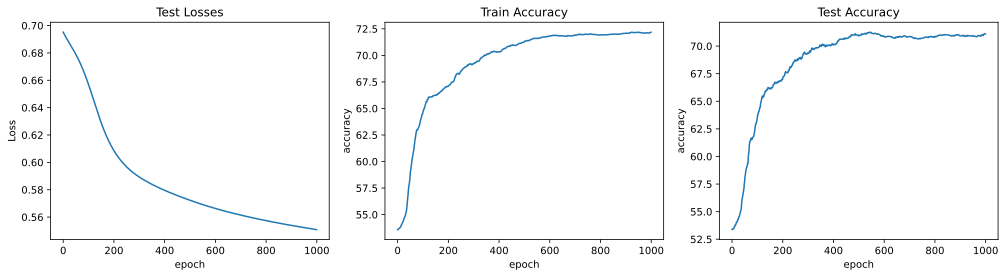

In [ ]:
# report accuracy
print('Train accuracy: %g%%' %totalacc)
print('Test accuracy: %g%%' %totalacc_test)

fig,ax = plt.subplots(1,3,figsize=(17,4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Test Losses')

ax[1].plot(ongoingAcc)
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_title('Train Accuracy')

ax[2].plot(ongoingAcc_test)
ax[2].set_ylabel('accuracy')
ax[2].set_xlabel('epoch')
ax[2].set_title('Test Accuracy')
plt.show()

# Visualize the results

Final accuracy: 96.8796%


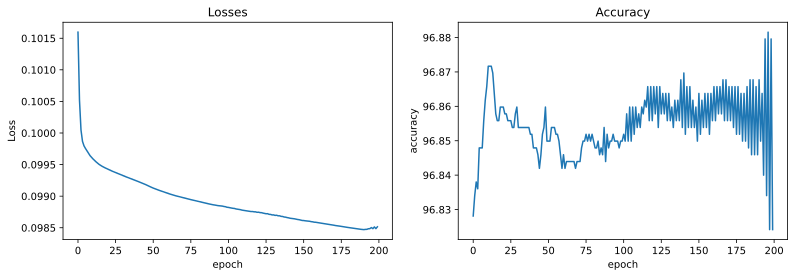

In [ ]:
# report accuracy
print('Final accuracy: %g%%' %totalacc)

fig,ax = plt.subplots(1,2,figsize=(13,4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(ongoingAcc)
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_title('Accuracy')
plt.show()
# run training again to see whether this performance is consistent

In [ ]:
# confirm that all model predictions sum to 1, but only when converted to softmax
sm = nn.Softmax(1)
torch.sum(sm(yHat),axis=1)

tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)